# Visualizing Models, Data and Traning with Tensorboard

In this tutorial, we'll learn how to:

1. Read in data and with appropriate transforms
2. Set up TensorBoard
3. Write to TensorBoard
4. Inspect a model architecutre using TensorBoard
5. Use TensorBoard to create interactive versions of the visualizations we created in last tutorial.

Specially, on point 5, we'll see:

* A couple of ways to insepect our training data
* How to track our model's performance as it trains
* How to assess our model's performance once it is trained

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])


# dataset
trainset = torchvision.datasets.FashionMNIST(
    './data', download=True, train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST(
    './data', download=True, train=False,
    transform=transform)

# dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
        
    img = img / 2 +  0.5  # unnormlize
    npimg = img.numpy()
    
    if one_channel:
        plt.imshow(npimg, cmap='Greys')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

0it [00:00, ?it/s]

100%|█████████▉| 26394624/26421880 [01:36<00:00, 682814.36it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



0it [00:00, ?it/s]

26427392it [01:50, 682814.36it/s]                              
 56%|█████▌    | 16384/29515 [00:15<00:00, 75450.16it/s]

0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




  0%|          | 0/4422102 [00:00<?, ?it/s]

  0%|          | 16384/4422102 [00:00<00:44, 99011.29it/s]

  1%|          | 49152/4422102 [00:00<00:37, 116198.73it/s]

  2%|▏         | 106496/4422102 [00:01<00:30, 142268.12it/s]

  4%|▍         | 188416/4422102 [00:01<00:22, 189016.06it/s]

  6%|▌         | 245760/4422102 [00:01<00:17, 236363.36it/s]

  7%|▋         | 319488/4422102 [00:01<00:13, 294687.75it/s]

  9%|▊         | 376832/4422102 [00:01<00:14, 276312.13it/s]

 13%|█▎        | 565248/4422102 [00:01<00:10, 369449.29it/s]

 15%|█▍        | 647168/4422102 [00:01<00:08, 434531.77it/s]

 16%|█▋        | 729088/4422102 [00:02<00:07, 488843.68it/s]

 18%|█▊        | 811008/4422102 [00:02<00:06, 520624.75it/s]

 20%|██        | 892928/4422102 [00:02<00:06, 576332.11it/s]

 22%|██▏       | 974848/4422102 [00:02<00:05, 618716.30it/s]

 24%|██▍       | 1056768/4422102 [00:02<00:05, 646519.99it/s]

 26%|██▌       | 1130496/4422102 [00:02<00:04, 665792.61it/s]

 27%|██▋       | 1204224

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw





32768it [00:23, 1395.37it/s]                            
4423680it [00:08, 540810.36it/s]                             
8192it [00:00, 12789.25it/s]            

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


We'll define a similar model architecutre from that tutorial, making only minor modifications to account for the fact that the images are now one channel instead of three and 28*28 instead of 32*32.

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

We'll define the same `optimizer` and `criterion` from before:

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

## TensorBord setup

Now we'll set up TensorBoard, importing `tensorboard` from `torch.utils` and defining a `SummaryWriter`, our key object for writing information to TensorBoard.

In [4]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fashion_mnist_experiment_1')

/Users/hotbaby/miniconda/miniconda3/envs/ml/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hotbaby/miniconda/miniconda3/envs/ml/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hotbaby/miniconda/miniconda3/envs/ml/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)]

## Writing to TensorBoard

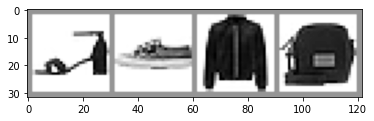

In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

![](https://pytorch.org/tutorials/_static/img/tensorboard_first_view.png)

## Inspect the model using TensorBoard

One of TensorBoad's strenghts is its ability to visualize model structures. Let's visualize the model we built.

In [6]:
writer.add_graph(net, images)
writer.close()

![](https://pytorch.org/tutorials/_static/img/tensorboard_model_viz.png)

Go ahead and double click on `Net` to see it expand, seeing a detailed view of the individual operations that make up the model.

## Adding a "Projector" to TensorBoard

We can visualize the lower dimensional representation of higher  dimensional data via the `add_embedding` method.

In [8]:
def select_n_random(data, labels, n=100):
    """
    Select n random datapoints and their corresponding lables from
    a dataset.
    """
    assert len(data) == len(labels)
    
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random iamges and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embedding
features = images.view(-1, 28*28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

In [9]:
images.shape, labels.shape

(torch.Size([100, 28, 28]), torch.Size([100]))

## Tracking model training with TensorBoard

In [101]:
# help functions

def images_to_probs(net, images):
    """
    Generates predictions adn corresonding probabilities from a
    trained network and a list of images.
    """
    output = net(images)
    # convert output probilities to predicted class
    _, pred_tensor = torch.max(output, 1)
    preds = np.squeeze(pred_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    """
    Generates matplotlib Figure using a trained network, along with
    images and labels from a batch, that shows the network's top 
    prediction along with its probability, alongnside the actual
    label, coloring this information based on wheterh the prediction
    was correct or not.
    Uses the "iamgess_to_probs" function.
    """
    preds, probs = images_to_probs(net, images)
    
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [104]:
running_loss = 0.0

for epoch in range(1):

        for i, data in enumerate(trainloader, 0):
            
            # get the inputs, data is a list of [inputs, labels]
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outpus = net(inputs)
            loss = criterion(outpus, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 1000 == 99:
                # log the running loss
                writer.add_scalar('training loass',
                                 running_loss / 1000,
                                 epoch * len(trainloader) + i)
                
                writer.add_figure('predictions vs. actuals',
                                 plot_classes_preds(net, inputs, labels),
                                 global_step=epoch*len(trainloader) + i)
                
                running_loss = 0.0
                
print('Finishing Training')

Finishing Training
